In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns


# Load training and testing data
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1]


# Fit model and predict test values
#y_pred = np.random.randint(y_train.min(), y_train.max(), X_test.shape[0])

# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
#test_header = "Id,PRP"
#n_points = X_test.shape[0]
#y_pred_pp = np.ones((n_points, 2))
#y_pred_pp[:, 0] = range(n_points)
#y_pred_pp[:, 1] = y_pred
#np.savetxt('my_submission.csv', y_pred_pp, fmt='%d,%f', delimiter=",",
#           header=test_header, comments="")

# Note: fmt='%d' denotes that all values should be formatted as integers which
# is appropriate for classification. For regression, where the second column
# should be floating point, use fmt='%d,%f'.
    

Note that it might be a good idea to transform one or more features into new features using basis functions. 
For instance, could the minimum and maximum memory features meaningfully be combined to one?

In [11]:
type(y_train)

numpy.ndarray

In [68]:
#Reshape ytrain to be two columns
#ytrain = np.reshape(y_train,(len(y_train),1))
MYCT = X_train[:,0]
MMIN = X_train[:,1]
MMAX = X_train[:,2]
CACH = X_train[:,3]
CHMIN = X_train[:,4]
CHMAX = X_train[:,5]

In [59]:
#Create variables for each feature

#for i in range(len(X_train)):
#    MYCT.append(X_train[i][0])
 #   MMIN.append(X_train[i][1])
  #  MMAX.append(X_train[i][2])
   # CACH.append(X_train[i][3])
    #CHMIN.append(X_train[i][4])
    #CHMAX.append(X_train[i][5])

What variables should we consider? Are all of them important? Which ones are more correlated with the CPU performance?

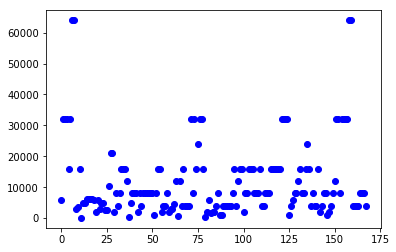

In [70]:
plt.plot(MMAX, 'bo')

In [80]:
d = {'MYCT': MYCT, 'MMIN': MMIN, 'MMAX': MMAX, 'CACH': CACH, 'CHMIN': CHMIN, 'CHMAX': CHMAX}
df = pd.DataFrame(data=d)
df

,CACH,CHMAX,CHMIN,MMAX,MMIN,MYCT
0,256.0,128.0,16.0,6000.0,256.0,125.0
1,32.0,32.0,8.0,32000.0,8000.0,29.0
2,32.0,32.0,8.0,32000.0,8000.0,29.0
3,32.0,32.0,8.0,32000.0,8000.0,29.0
4,32.0,16.0,8.0,16000.0,8000.0,29.0
5,64.0,32.0,16.0,32000.0,16000.0,23.0
6,64.0,32.0,16.0,64000.0,16000.0,23.0
7,128.0,64.0,32.0,64000.0,32000.0,23.0
8,0.0,2.0,1.0,3000.0,1000.0,400.0
9,4.0,6.0,1.0,3500.0,512.0,400.0


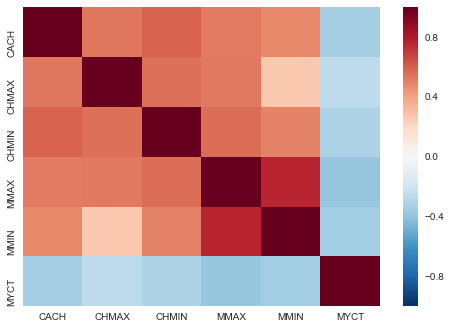

In [81]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)